# **Autograd: Automatic Differentiation in PyTorch**

The autograd package in PyTorch provides automatic differentiation for all operations on tensors. It allows us to perform gradient calculations, which are crucial for training neural networks. Let's break down the key concepts and code examples step by step.

**Basic Concepts**

**Tensor**: The central class in ``autograd``. If a tensor's attribute ``requires_grad`` is set to ``True``, it will track all operations on it. This tracking is used to calculate gradients.

**Function**: Represents a node in the computation graph. Each tensor has a ``grad_fn`` attribute referencing a Function that created it, except for tensors created by the user.

## **Example 1: Basic Operations and Gradient Calculation**

### **1. Create a tensor with requires_grad=True:**

In [54]:
import torch

# This creates a 3x3 tensor of ones with gradient tracking enabled.
x = torch.ones(3, 3, requires_grad=True)
print(x)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)


### **2. Perform an operation on the tensor:**

In [55]:
# y is a new tensor resulting from multiplying x by 2. Since y is the result of an operation on x, it has a ``grad_fn``.
y = x * 2
print(y)
print(y.grad_fn)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)


In [56]:
# z is the result of element-wise cubing y. out is the sum of z.
z = y ** 3
out = z.sum()
print(z, "\n\n", out)

tensor([[8., 8., 8.],
        [8., 8., 8.],
        [8., 8., 8.]], grad_fn=<PowBackward0>) 

 tensor(72., grad_fn=<SumBackward0>)


### **3. Changing ``requires_grad`` in-place:**

In [57]:
# The below code shows how to change the requires_grad attribute of an existing tensor in-place.
a = torch.randn(3, 3)
a = ((a + 4) / (a - 2))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).mean()
print(b.grad_fn)

False
True


### **4. Backward pass to calculate gradients:**

In [58]:
# This calculates the gradient of ``out`` w.r.t x.
out.backward()
print(x.grad)

tensor([[24., 24., 24.],
        [24., 24., 24.],
        [24., 24., 24.]])


Mathematically,

**Gradient of out with respect to z**: ∂out/∂z_i = 1 for all i since out is the sum of all elements in z.

**Gradient of z with respect to y**: z_i = y_i^3, so ∂z_i/∂y_i = 3 * y_i^2.

**Gradient of y with respect to x**: y_i = 2 * x_i, so ∂y_i/∂x_i = 2.

Using the chain rule to combine these gradients:

                    ∂out/∂x_i = ∂out/∂z_i * ∂z_i/∂y_i * ∂y_i/∂x_i

                    ∂out/∂x_i = 1 * (3 * y_i^2) * 2

                    ∂out/∂x_i = 6 * y_i^2

                    Since y = 2 * x and x = 1: y = 2 * 1 = 2

                    ∂out/∂x_i = 6 * 2^2 = 6 * 4 = 24

Thus, the gradient of out w.r.t x is:

                    x.grad = tensor([[24., 24., 24.],
                                    [24., 24., 24.],
                                    [24., 24., 24.]])

## **Example 2: Vector-Jacobian Product**

The Vector-Jacobian Product (VJP) is an important concept in automatic differentiation, especially for neural networks. It involves computing the product of a vector with the Jacobian matrix of a vector-valued function.

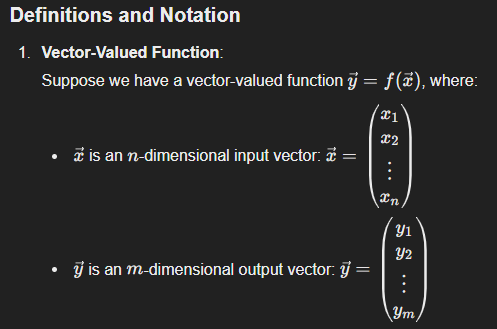                      
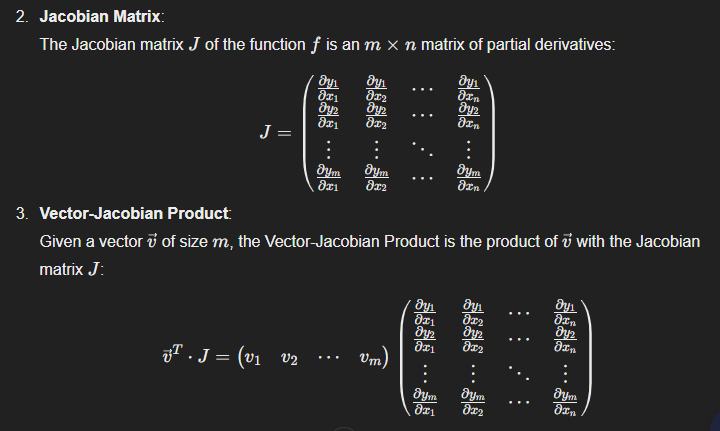
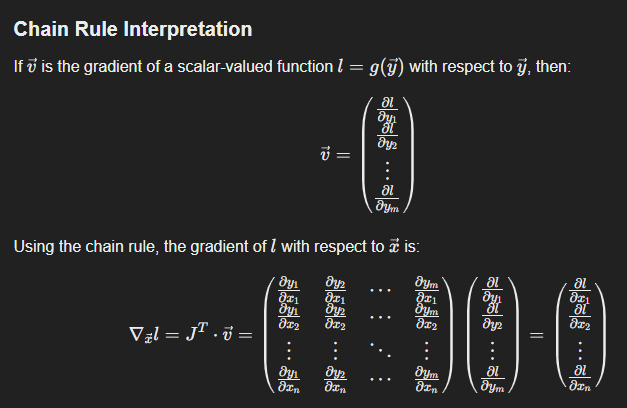

### **1. Create a tensor with gradient tracking:**

In [59]:
x = torch.randn(4, requires_grad=True)
y = x * 3
print(y)
while y.data.norm() < 500:
    y = y * 2
    print(y.data.norm())

print(y)

tensor([ 6.7698,  3.5572,  3.5769, -3.3193], grad_fn=<MulBackward0>)
tensor(18.1434)
tensor(36.2868)
tensor(72.5737)
tensor(145.1474)
tensor(290.2947)
tensor(580.5895)
tensor([ 433.2652,  227.6637,  228.9226, -212.4361], grad_fn=<MulBackward0>)


### **2. Compute the vector-Jacobian product:**

In [60]:
# Create a tensor of size 4 with requires_grad=True
x = torch.randn(4, requires_grad=True)

# Perform element-wise multiplication and scaling until the norm of y is at least 100.
y = x * 3
print(y)

# Initialize iteration counter
iteration_count = 0

while y.data.norm() < 100:
    y = y * 2
    iteration_count += 1
    print(f"Iteration {iteration_count}: Norm = {y.data.norm()}")

# Vector-Jacobian Product: We define a vector v and compute the vector-Jacobian product by calling backward(v) on y.
v = torch.tensor([0.2, 0.5, 0.3, 0.4], dtype=torch.float)   # Vector to multiply with Jacobian
y.backward(v)       # Compute vector-Jacobian product
print(x.grad)

tensor([-3.5299,  4.4830,  0.2980, -0.0549], grad_fn=<MulBackward0>)
Iteration 1: Norm = 11.42795467376709
Iteration 2: Norm = 22.85590934753418
Iteration 3: Norm = 45.71181869506836
Iteration 4: Norm = 91.42363739013672
Iteration 5: Norm = 182.84727478027344
tensor([19.2000, 48.0000, 28.8000, 38.4000])


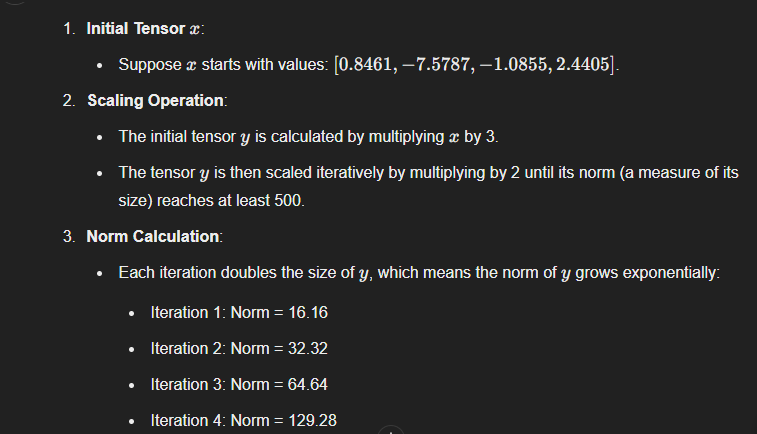

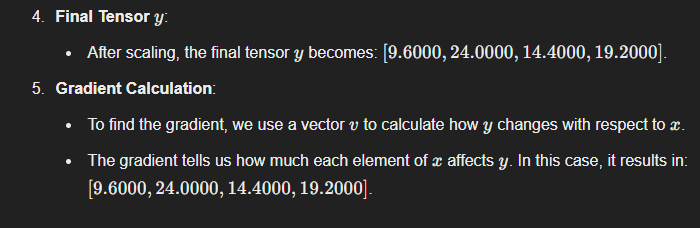

The loop stops after the 4th iteration when the norm exceeds the threshold of 100. This confirms that the tensor y used for the backward computation was scaled by 2^4 (16). 

## **Example 3: Disabling Gradient Tracking**

Disable autograd for Tensors with ``.requires_grad=True`` by using ``with torch.no_grad():`` or ``.detach()`` to create a new Tensor that doesn’t track gradients.

### **1. Disable gradient tracking using ``no_grad``:**

In [61]:
# This block shows how to temporarily disable gradient tracking using torch.no_grad().
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


### **2. Detach a tensor:**

In [62]:
# This code detaches y from the computation graph, meaning it no longer tracks operations. 
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
# This checks if all elements in x are equal to those in y. 
# It prints True because y is a detached view of x, so their values are identical.
print(x.eq(y).all())

True
False
tensor(True)
